In [1]:
### Import modules
from torch.distributions import Categorical
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
gamma = 0.99

In [3]:
class Pi(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Pi, self).__init__()
        layers = [
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        ]
        self.model = nn.Sequential(*layers)
        self.onpolicy_reset() 
        self.train()
        
    def onpolicy_reset(self):
        self.log_probs = []
        self.rewards = []
        
    def forward(self, x):
        pdparams = self.model(x)
        return pdparams
    
    def act(self, state):
        x = torch.from_numpy(state.astype(np.float32)) #Преобразование в тензор
        pdparams = self.model(x) # прямой проход
        pd = Categorical(logits=pdparams) # вероятностное распределение
        action = pd.sample() # pi(a|s) выбор действия по распределению pd
        log_prob = pd.log_prob(action) # логарифм вероятности pi(a|s)
        self.log_probs.append(log_prob) # сохраняем для обучения
        return action.item()
           
    

In [4]:
def train(pi, optimizer):
    # Внутренний цикл градиентного восхождения в алгоритме REINFORCE
    T = len(pi.rewards)
    rets = np.empty(T, dtype=np.float32)
    future_RET = 0.0
    # эффективное вычисление отдачи
    for t in reversed(range(T)):
        future_RET = pi.rewards[t] + gamma * future_RET
        rets[t] = future_RET
    rets = torch.tensor(rets)
    log_probs = torch.stack(pi.log_probs)
    loss = - log_probs * rets # член градиента; знак минуса для максимизации
    loss = torch.sum(loss)
    optimizer.zero_grad()
    loss.backward() # обратное распространение, вычисление градиентов
    optimizer.step() # градиентное восхождение, обновление весов
    return loss


In [6]:
def main():
    env = gym.make('CartPole-v1')
    in_dim = env.observation_space.shape[0] #4
    out_dim = env.action_space.n
    pi = Pi(in_dim, out_dim) # стратегия pi_theta для REINFORCE
    optimizer = optim.Adam(pi.parameters(), lr=0.01)
    for episode in range(300):
        state = env.reset()
        for t in range(200):
            action = pi.act(state)
            state, reward, done, _= env.step(action)
            pi.rewards.append(reward)
            env.render()
            if done:
                break
        loss = train(pi, optimizer) # обучение в эпизоде
        total_reward = sum(pi.rewards)
        solved = total_reward > 195.0
        pi.onpolicy_reset()
        print(f"Episode: {episode}, Reward: {total_reward}, Solved: {solved}, loss: {loss}")

In [ ]:
if __name__ == '__main__':
    main()

Episode: 0, Reward: 20.0, Solved: False, loss: 138.49853515625
Episode: 1, Reward: 20.0, Solved: False, loss: 140.98812866210938
Episode: 2, Reward: 17.0, Solved: False, loss: 98.65751647949219
Episode: 3, Reward: 16.0, Solved: False, loss: 86.7340087890625
Episode: 4, Reward: 26.0, Solved: False, loss: 212.49575805664062
Episode: 5, Reward: 18.0, Solved: False, loss: 106.61144256591797
Episode: 6, Reward: 29.0, Solved: False, loss: 273.7311706542969
Episode: 7, Reward: 25.0, Solved: False, loss: 183.83917236328125


E:\temp\ipykernel_11692\4152795310.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


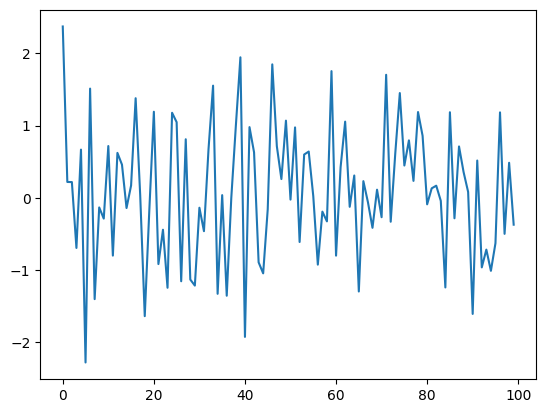

In [8]:
import numpy as np
import matplotlib.pyplot as plt

m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    ax.clear()
    ax.plot(matrix[i,:])
    fig.canvas.draw()